2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [1]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [2]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [53]:
uniqueUsers = userArtistDF.select("userID").distinct().count()
print("Total n. of users: ", uniqueUsers)


Total n. of users:  148111


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [113]:
uniqueArtists = userArtistDF.select("artistID").distinct().count()
print("Total n. of artists: ", uniqueArtists)


Total n. of artists:  1631028


#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

In [114]:

max_userid= userArtistDF.select("userID").sort("userID",ascending=0).take(1)
min_userid= userArtistDF.select("userID").sort("userID",ascending=1).take(1)

print("Max User ID= ",max_userid)
print("Min User ID= ",min_userid)


Max User ID=  [Row(userID=2443548)]
Min User ID=  [Row(userID=90)]


In [115]:
#Or we can use the describe() function
userArtistDF.describe('userID').show()

+-------+------------------+
|summary|            userID|
+-------+------------------+
|  count|          24296858|
|   mean|1947573.2653533637|
| stddev| 496000.5551819133|
|    min|                90|
|    max|           2443548|
+-------+------------------+



#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [116]:
max_artistid= userArtistDF.select("artistID").sort("artistID",ascending=0).first()
min_artistid= userArtistDF.select("artistID").sort("artistID",ascending=1).first()

print("Max Artist ID= ",max_artistid)
print("Min Artist ID= ",min_artistid)

#We can also use the describe() function
userArtistDF.describe('artistID').show()

Max Artist ID=  Row(artistID=10794401)
Min Artist ID=  Row(artistID=1)
+-------+------------------+
|summary|          artistID|
+-------+------------------+
|  count|          24296858|
|   mean|1718704.0937568964|
| stddev| 2539389.092428355|
|    min|                 1|
|    max|          10794401|
+-------+------------------+



We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

In [5]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy("userID").sum("playCount").collect()
#print(userActivity[0:5])

for elem in userActivity[0:5]:
    print("The user with ID %d has a total play count of %d." %(elem[0],elem[1]))


The user with ID 2289066 has a total play count of 51.
The user with ID 2289173 has a total play count of 5938.
The user with ID 2290086 has a total play count of 1080.
The user with ID 2291343 has a total play count of 37.
The user with ID 2291463 has a total play count of 8802.


#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

[     0      1      2 ... 148108 148109 148110]


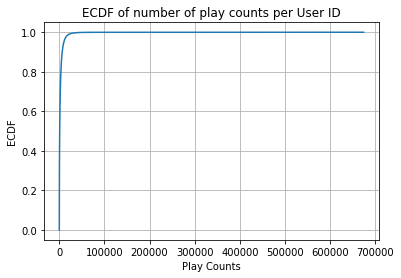

In [118]:

pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))
plt.step(Y,yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()


<div class="alert alert-warning">Let us try to zoom in the curve. It seems that the curve jumps to approximately <b>1</b> at the beginning, so I am going to zoom in that portion. Let's find at what number of <b>Play Counts</b> does the <b>ECDF</b> of number of play counts equal <b>0.9</b>.</div>

In [119]:
Y[np.max(np.where(yvals<=0.9))]
#np.where(yvals<=0.9) gives us all the indices where yvals<=0.9
#I want only the last one as that corresponds to the greatest ECDF so I use the np.max() function

6484

[     0      1      2 ... 148108 148109 148110]


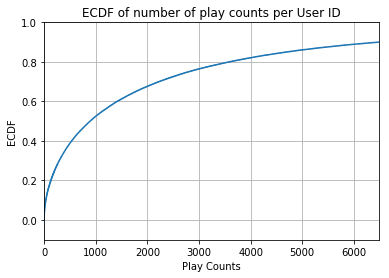

In [120]:
pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt.step(Y,yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.axis([0,6484,-.1,1])
plt.show()

<div class="alert alert-warning">Let's draw the curve on a logarithmic scale</div>

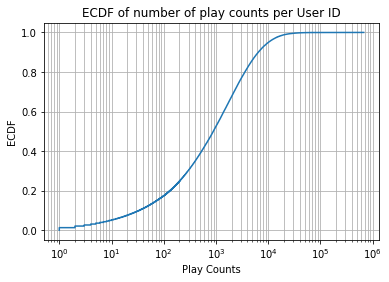

In [121]:
pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

plt.step(Y,yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.xscale('log')
plt.title('ECDF of number of play counts per User ID')
plt.show()


<div class="alert alert-warning">To visualise the important percentiles, we can use an under-estimated plot called the <b>box plot</b>.
The <b>box plot</b> is a standardized way of displaying the distribution of data based on the five important numbers: minimum, first quartile, median, third quartile, and maximum. In the simplest box plot, the central rectangle spans the first quartile to the third quartile (the interquartile range or IQR). A segment inside the rectangle shows the median and "whiskers" above and below the box show the locations of the minimum and maximum.
Check <a href="http://www.physics.csbsju.edu/stats/box2.html">here</a> for more info.</div>



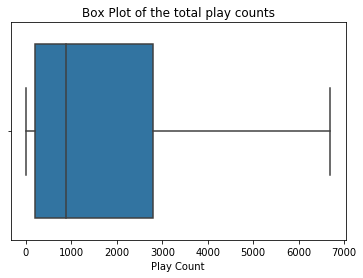

In [122]:
import seaborn as sns
sns.boxplot(Y,showfliers=False)

plt.title('Box Plot of the total play counts')
plt.xlabel('Play Count')
plt.show()

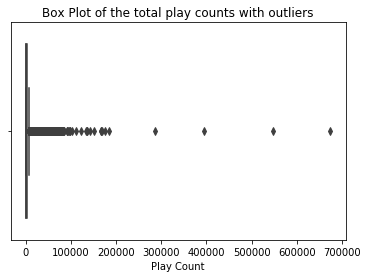

In [123]:
sns.boxplot(Y)
plt.title('Box Plot of the total play counts with outliers')
plt.xlabel('Play Count')
plt.show()

In [124]:
#calculation of percentiles
percentiles=[0.25,0.5,0.75,0.9]

for p in percentiles:
    print("There are ",p*100,"% users whose play counts are less than or equal to ",Y[np.max(np.where(yvals<=p))],".")

There are  25.0 % users whose play counts are less than or equal to  204 .
There are  50.0 % users whose play counts are less than or equal to  892 .
There are  75.0 % users whose play counts are less than or equal to  2800 .
There are  90.0 % users whose play counts are less than or equal to  6484 .


<div class="alert alert-warning"><br>The boxplot shows us that the median is skewed to the left of the data. This means we have a relatively low median <b>(892)</b>. Thus the data we have is obviously skewed and not uniformly distributed. We notice here that <b>25%</b> of users have play counts less than 204. This seems a little low. There are actually some users who only have <b>1</b> play count. For those users, we are going to have a hard time recommending something for them. We also have <b>10%</b> of users that have play counts more than 6484. This is good for our recommender algorithm if the users listen to different songs and artists. However, a high number of play counts doesn't mean something good. Some users might be very curious and listen to songs of different artists,different genres, and different tastes. These outliers form  a problem.
<br><br>
Usually, we define the <b>outliers</b> as those whose <b>play count</b> is outside the range <b>[Q1-1.5xIQR,Q3+1.5xIQR]</b> as seen in the box plots, where:<br>
<b>Q1</b> is the 25% percentile<br>
<b>Q3</b> is the 75% percentile<br>
<b>IQR</b>=<b>Q3</b> - <b>Q1</b> is the interquartile range<br>
<br>
We observe that we have many <b>outliers</b> according to this defintion. However,this definition does not apply here as the data is skew and not normally distributed. So to solve this we have different critieria for choosing an outlier. We are first going to look at the maximum play counts of each user and try to reason what the threshold of a play count of an outlier would be.
We are also going to also look at the value:
<br>
<b>Mean + 3 x Standard Deviaition</b> <br> and from these critieria, we will try to conculde an appropriate threshold.
We won't do this now. After we replace the mispelled IDs by the standard ones, we will define a certain threshold and remove any outlier.

<br>


</div>

<div class="alert alert-danger"><b>Experiment</b> <br>Let's find how many users have a <b>play count</b> of <b>1</b>.</div>

In [125]:
#np.where(Y==1) gives me an array of indices where the play count is equal to 1
#We take the maximim value and add 1 because induces are zero-based
np.max(np.where(Y==1))+1

1848

In [126]:
#% of users that have a play count of one to the 25% of all users
1848*100/(0.25*uniqueUsers)

4.990851456002592

<div class="alert alert-warning"> We hope that mapping from mispelled IDs to standard IDs would fix this issue since artists with a play count of <b>1</b> are usually mispelled artists.</div>

<div class="alert alert-danger"><b>End of Experiment</b> </div>

<div class="alert alert-danger"><b>Experiment</b> <br>Let's visualise the data more.</div>

<div class="alert alert-warning">Let's plot a scatter plot for some users showing the different artists and the number of play counts.</div>

In [127]:
#this function draws for a given userID a scatter plot for the artists vs play counts
def graph_user(userID):
    df=userArtistDF[userArtistDF.userID==userID].toPandas()#dataframe containing artists IDs and play counts of a user
    pc_01=df[df['playCount'].values==1]['playCount'].count()#this variables stores the number of play counts which are equal to 1 for the given userID
    pc_tot=df['playCount'].sum()#this variables stores the total number of play counts for the given userID
    print("For the user with ID:",userID,", we have",pc_01,"play counts out of",pc_tot,"which are equal to 1.")
    plt.figure(figsize=(35, 10))
    sc=plt.scatter(x=list(range(df['artistID'].count())), y=df['playCount'].values, c=df['playCount'].values, cmap='viridis')
    plt.colorbar(sc)
    plt.show()

For the user with ID: 1000002 , we have 313 play counts out of 11430 which are equal to 1.


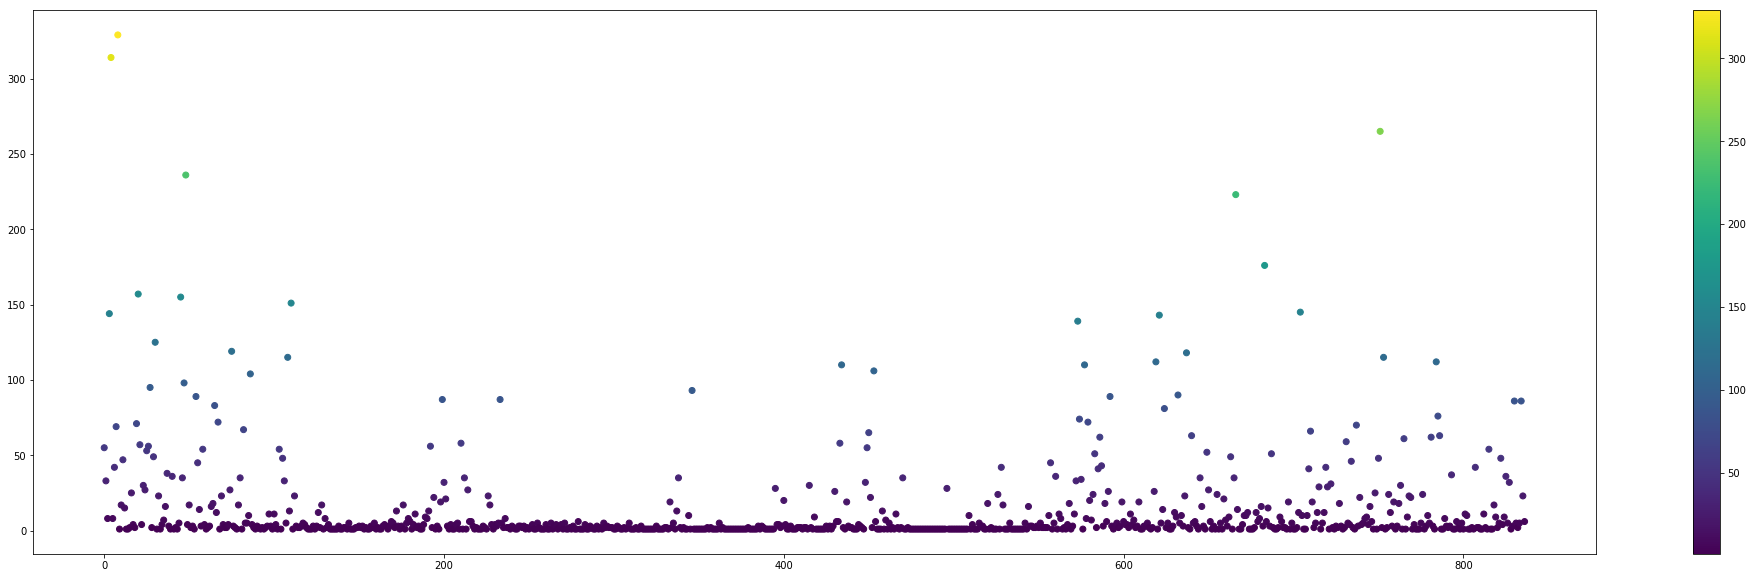

In [128]:
graph_user(1000002)

For the user with ID: 2286103 , we have 95 play counts out of 3496 which are equal to 1.


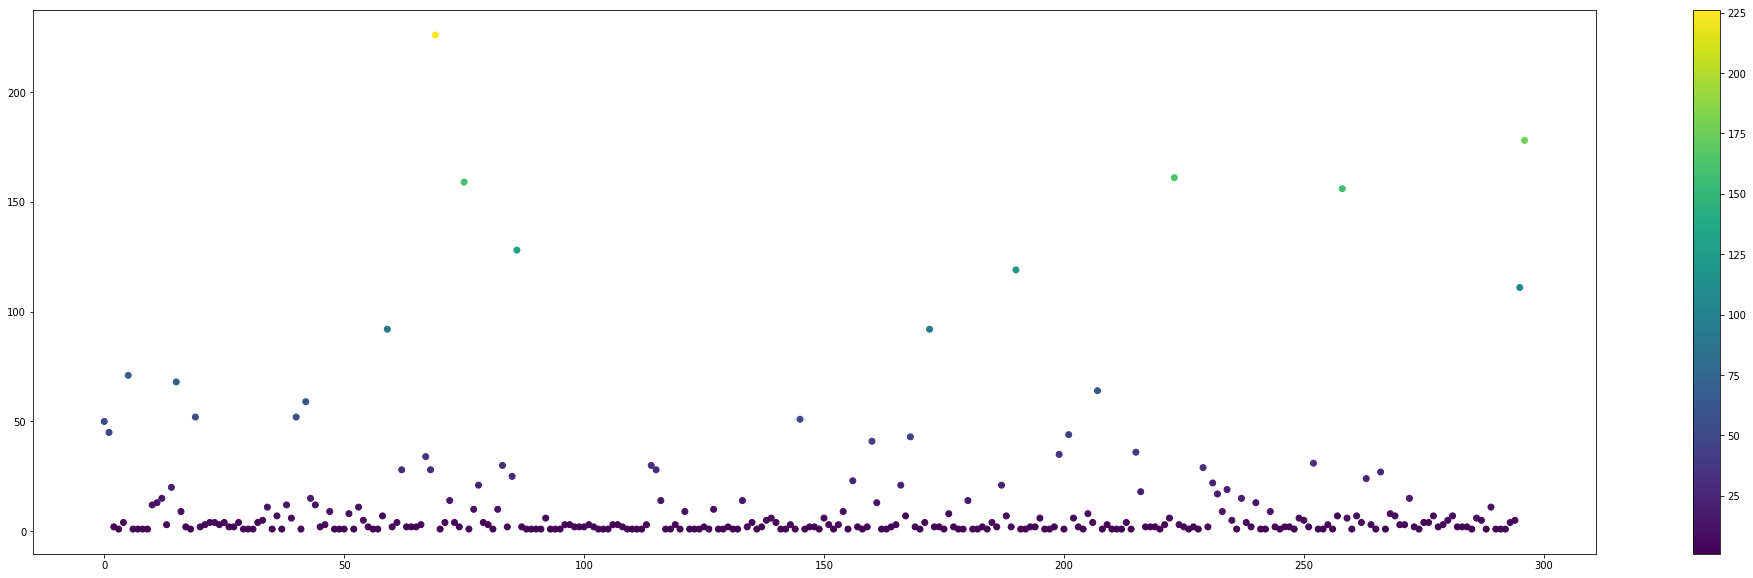

In [129]:
graph_user(2286103)

<div class="alert alert-warning">We can see that we have many values equal to 1. Also users have different number of play counts. Some users have a max play count of less than 300 while others have play counts in the order of hundreds of thousands.<br>

Let's see the greatest number of play counts per user.</div>

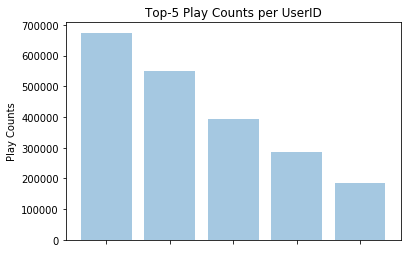

In [130]:
top_5_pcpu=Y[-5:] #pcpu=play counts per user
plt.bar(np.arange(len(top_5_pcpu)),top_5_pcpu[::-1],align='center', alpha=0.4)
plt.ylabel('Play Counts')
plt.title('Top-5 Play Counts per UserID')
plt.tick_params(labelbottom='off')
plt.show()


In [131]:
top_5_pcpu[::-1]

array([674412, 548427, 393515, 285978, 183972])

<div class="alert alert-warning">Let's reason a bit about the above values. The dataset was made in May 2005. The company that made this dataset <b>LightFM</b> was found in the beginning of 2002.
If we assume that company started to collect data since 2002 and if we assume that each day a user plays 10 songs, we get the following play count: 
</div>

In [132]:
3*365*10 #3 years* 365 days/year * 10 play counts/day

10950

<div class="alert alert-warning">We can see that we definitely have a lot of outliers. The only possible explanation to this is that these outliers with very high play counts is that they were certain bots continuously playing songs.
</div>

<div class="alert alert-danger"><b>End of Experiment</b></div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

In [133]:

# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDF.groupBy("artistID").sum("playCount").collect()


[      0       1       2 ... 1631025 1631026 1631027]


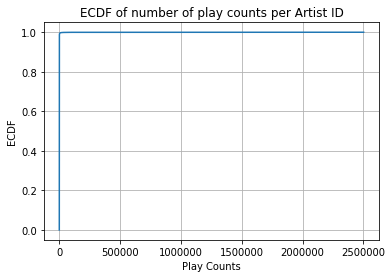

In [134]:

pdf = pd.DataFrame(data=artistPopularity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt.step( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID')
plt.show()


<div class="alert alert-warning">Let us try to zoom in the curve. It seems that the curve jumps to approximately <b>1</b> at the beginning, so I am going to zoom in that portion. Let's find at what number of <b>Play Counts</b> does the <b>ECDF</b> of number of play counts equal <b>0.9</b>.</div>

In [135]:
Y[np.max(np.where(yvals<=0.9))]


45

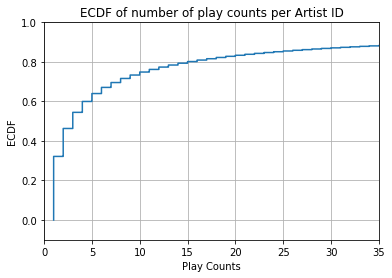

In [136]:

pdf = pd.DataFrame(data=artistPopularity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))
plt.step( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID')
plt.axis([0,35,-.1,1])
plt.show()


<div class="alert alert-warning"> Let's use a <b>log scale</b> for the x-axis.</div>

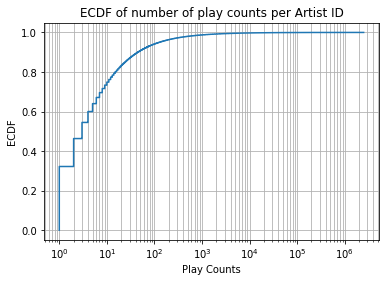

In [137]:

pdf = pd.DataFrame(data=artistPopularity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))


plt.step( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.xscale('log')
plt.title('ECDF of number of play counts per Artist ID')
plt.show()


<div class="alert alert-warning">
To visualise the important percentiles, we use a <b>box plot</b>.
</div>



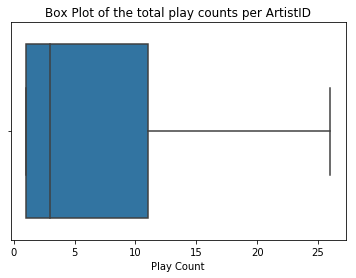

In [138]:
sns.boxplot(Y,showfliers=False)
plt.title('Box Plot of the total play counts per ArtistID')
plt.xlabel('Play Count')
plt.show()

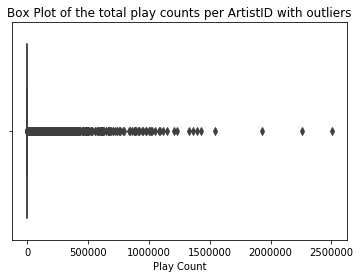

In [139]:
sns.boxplot(Y)
plt.title('Box Plot of the total play counts per ArtistID with outliers')
plt.xlabel('Play Count')

plt.show()

<div class="alert alert-warning">
Let's calculate the percentiles.</div>

In [140]:
percentiles=[0.25,0.5,0.75,0.9]

for p in percentiles:
    print("There are ",p*100,"% artists whose play counts are less than or equal to ",Y[np.max(np.where(yvals<=p))],".")

There are  25.0 % artists whose play counts are less than or equal to  1 .
There are  50.0 % artists whose play counts are less than or equal to  3 .
There are  75.0 % artists whose play counts are less than or equal to  11 .
There are  90.0 % artists whose play counts are less than or equal to  45 .


<div class="alert alert-warning">
The boxplot shows us that the median is skewed to the left of the data. This means we have a relatively low median <b>(3)</b>. Thus the data we have is obviously skewed and not uniformly distributed. We notice here that <b>25%</b> of users have a play count less than 1.<br><br> This very strange observation is due to the fact that our data is not clean. We have the same artist but with different names. The different names contain the intended artist's song,album,... and this is a big problem. We should deal with those artists whose play count is <b>1</b> because they will seriously affect our recommender algorithms. <br><br>We also have <b>10%</b> of artists that have play counts more than 45. This also seems a bit stange as of the millions of artists, only <b>10%</b> of them have play counts greater than 45. This also has to due somewhat with the unclean data as some artists are mispelled more than a 500 times!<b>(See below for calculations)</b><br>

The outliers we have here are those artists whose play count is one. We hope that the <b>artist_alias.txt</b> will fix this issue. There are also artists who have very high play counts. They seem to be very successful. ALso we have artists with weird names. We will explore them more in later sections.</div>

<div class="alert alert-danger"><b>Experiment</b> <br>Let's visualise some artists along with their play counts.</div>

In [3]:
#this function draws for a given artistID a scatter plot for the song vs play counts
def graph_artist(artistID):
    df=userArtistDF[userArtistDF.artistID==artistID].toPandas()
    print("This artist has been listened by",df['artistID'].count(),"users with a total play count of",df['playCount'].sum(),".")
    plt.figure(figsize=(35, 10))
    sc=plt.scatter(x=list(range(df['artistID'].count())), y=df['playCount'].values, c=df['playCount'].values, cmap='viridis')
    plt.colorbar(sc)
    plt.ylabel('Play Count')
    plt.show()

This artist has been listened by 32327 users with a total play count of 1542806 .


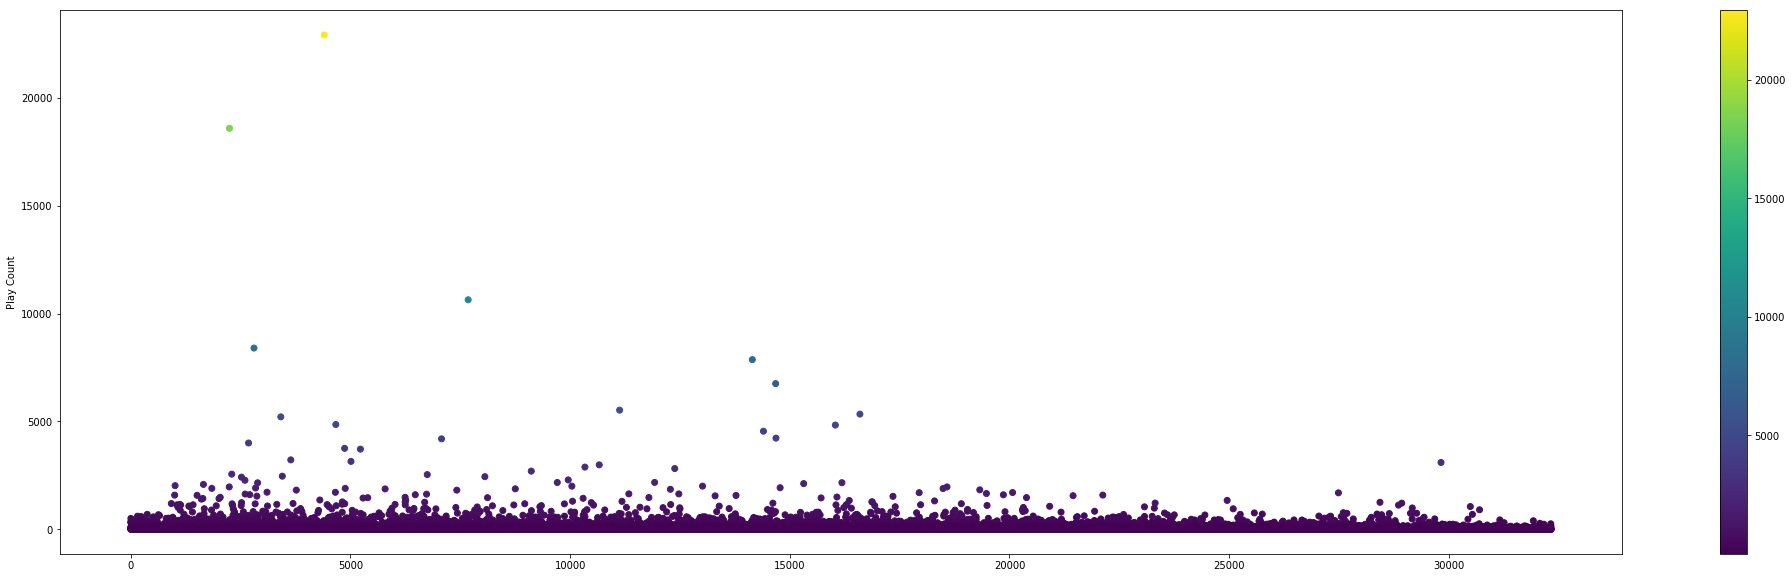

In [142]:
graph_artist(1000024)

This artist has been listened by 1 users with a total play count of 1 .


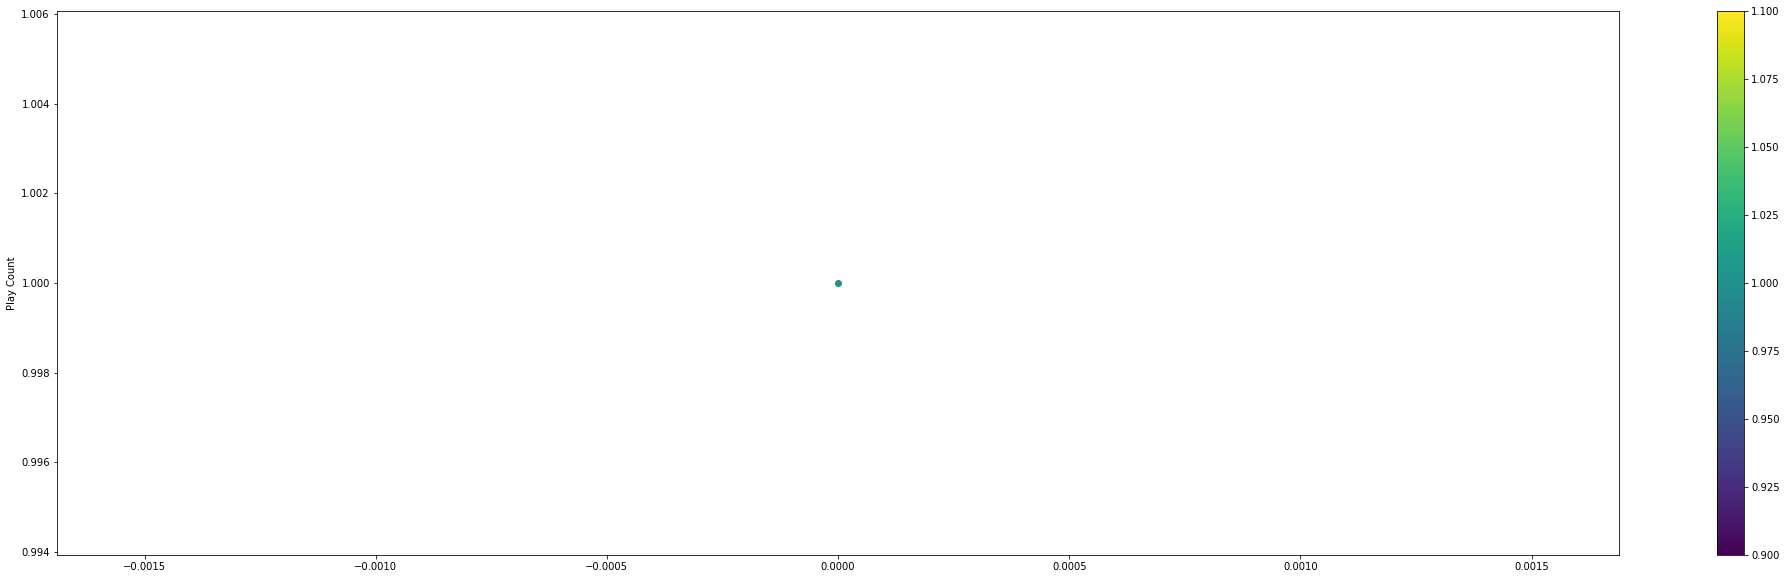

In [143]:
graph_artist(10794401)

This artist has been listened by 1 users with a total play count of 1 .


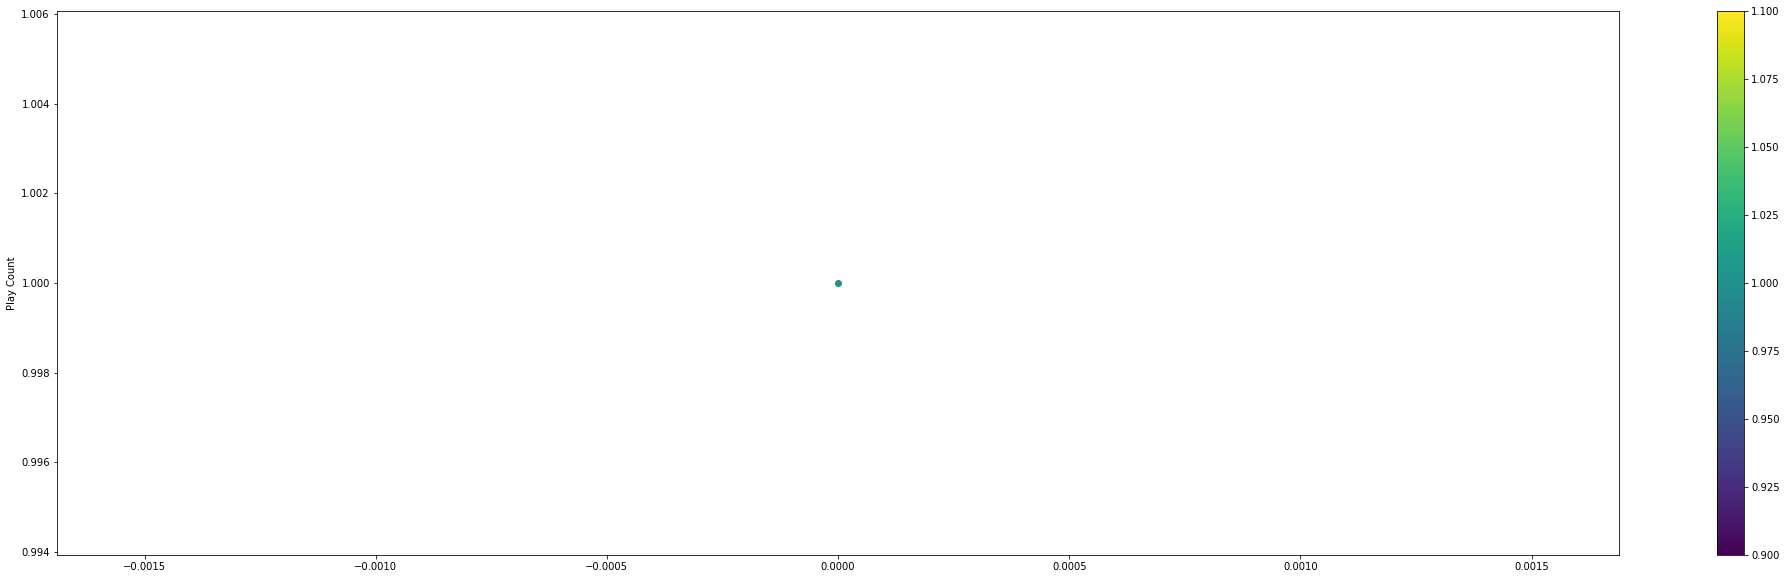

In [144]:
graph_artist(10237208)

<div class="alert alert-warning">We can see something strange here. We have multiple artists whose have been listened by only one user and only one time. The only explanation to that,as stated before, is the corrupted data that we have.

We have song names, album names, or anything irrelevant in the place of the artists' names.</div>

<div class="alert alert-danger"><b>End of Experiment</b></div>

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

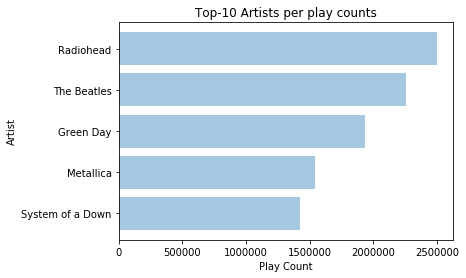

In [145]:

sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[:5]

artistID = [w[0] for w in sortedArtist]
artistnames=[get_artist_name(w) for w in artistID] #get_artist_name() is a function to find the name of an artists given ID 
                                                   #we defined it later 

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistnames[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artists per play counts')
plt.show()


<div class="alert alert-warning">By looking alone at the top 5 artists,we see that the values are reasonable and that there is no artist who is an outlier with respect to the others. All artists here are very successful one and it is no surprise that they have such high play counts.<br><br>
<b>However</b>,looking at these values is not enough!
We have some artists who only have a play count of <b>1</b>.</div>

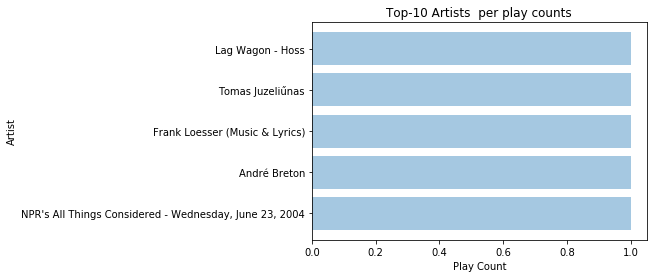

In [146]:
sortedArtist = sorted(artistPopularity, key = lambda x: x[1])[:5]

artistID = [w[0] for w in sortedArtist]
artistnames=[get_artist_name(w) for w in artistID]


y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistnames[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artists  per play counts')
plt.show()


<div class="alert alert-warning"> We can see here an example of corrupted data. We have an artist with the name <b>NPR's All Things Considered -Wednesday,June 23,2004</b> which is definitely not one.</div>

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [6]:

customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter ='\t', mode='DROPMALFORMED') \
    .load(base+ "artist_data.txt", schema= customSchemaArtist)
    
artistDF.show(5,truncate=False)


+--------+----------------------------+
|artistID|name                        |
+--------+----------------------------+
|1134999 |06Crazy Life                |
|6821360 |Pang Nakarin                |
|10113088|Terfel, Bartoli- Mozart: Don|
|10151459|The Flaming Sidebur         |
|6826647 |Bodenstandig 3000           |
+--------+----------------------------+
only showing top 5 rows



#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [5]:

# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", artistDF.name) > 0].show(20,truncate=False)

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()


+--------+----------------------------------------------+
|artistID|name                                          |
+--------+----------------------------------------------+
|10586006|Dusty Springfield/Aerosmith                   |
|6946007 |Aerosmith/RunDMC                              |
|10475683|Aerosmith: Just Push Play                     |
|1083031 |Aerosmith/ G n R                              |
|6872848 |Britney, Nsync, Nelly, Aerosmith,Mary J Blige.|
|10586963|Green Day - Oasis - Eminem - Aerosmith        |
|10028830|The Aerosmith Antology2                       |
|10300357|Run-DMC + Aerosmith                           |
|2027746 |Aerosmith by MusicInter.com                   |
|1140418 |[rap]Run DMC and Aerosmith                    |
|10237208|Aerosmith + Run DMC                           |
|10588537|Aerosmith, Kid Rock, & Run DMC                |
|9934757 |Aerosmith - Big Ones                          |
|10437510|Green Day ft. Oasis & Aerosmith               |
|6936680 |RUN 

<div class="alert alert-warning">They are definitely pointing to the same artist. The artists ID <b>1000010</b> is the true ID of the artist,however, the artist ID <b>2082323</b> is a mispelled ID because the data we have is not clean. Mispelled IDs usually point to songs,albums,or anything else related to the intended artist. For example,we also have some entries such as <b>Green Day - Oasis - Eminem - Aerosmith</b> that has to point to several artists, but in our case is only pointing to a single artist.<br></div>

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [8]:

customSchemaArtistAlias = StructType([ \
    StructField( "mispelledID",LongType(),True ), \
    StructField( "standardID",LongType(),True )])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='False',delimiter='\t') \
    .load(base + "artist_alias.txt" , schema=customSchemaArtistAlias)

artistAliasDF.show(5)


+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    1092764|   1000311|
|    1095122|   1000557|
|    6708070|   1007267|
|   10088054|   1042317|
|    1195917|   1042317|
+-----------+----------+
only showing top 5 rows



<div class="alert alert-danger"><b>Experiment: Finding top mispelled artists</b></div>

<div class="alert alert-warning">Let's find the top mispelled artists!
<br>
We will start by writing a function that takes an artist ID as an input and finds the artist's name.</div>

In [10]:
def get_artist_name(artistID):
    a=artistDF[artistDF.artistID==artistID]
    a = a[['name']].collect()
    return a[0][0]


In [6]:
mispelled_art_dict=artistAliasDF.groupBy('standardID').count().orderBy('count',ascending=0) \
                     .limit(5).rdd.collectAsMap()

#1)group by standard ID,and sort by their count ,the more the count the more the artist is mispelled   
#2)take first 5 elements   
#3)collect as dictionary,key=artistID,value=no. mispelled IDs 

In [153]:
mispelled_art_names=[get_artist_name(w) for w in list(mispelled_art_dict.keys())]  #list of mispelled artist names

In [154]:
mispelled_art_names

['Metallica', '[unknown]', 'Pink Floyd', 'South Park', 'Linkin Park']

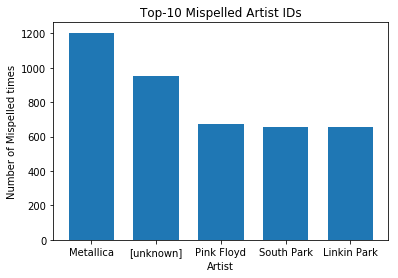

In [155]:
mispelled_art_count=list(mispelled_art_dict.values())
indexes = np.arange(len(mispelled_art_names))
width = 0.7
plt.bar(indexes, mispelled_art_count, width)
plt.xticks(indexes , mispelled_art_names)
plt.ylabel('Number of Mispelled times')
plt.xlabel('Artist')
plt.title('Top-10 Mispelled Artist IDs')
plt.show()


In [156]:
mispelled_art_dict.keys()

dict_keys([1000024, 1034635, 82, 1003694, 1854])

In [157]:
artistDF[artistDF.name=='[unknown]'].show() #find artists with the name "[unknown]"

+--------+---------+
|artistID|     name|
+--------+---------+
| 1034635|[unknown]|
+--------+---------+



<div class="alert alert-warning">The artist <b>[unknown]</b> is useless for recommendations and we need to deal with it. </div>

<div class="alert alert-warning">Also, from the multiple times that we trained the model,we found the following "bad" artists.</div>

In [58]:
artistDF[artistDF.name=='Various Artists'].show() #find artists with the name "Various Artists"

+--------+---------------+
|artistID|           name|
+--------+---------------+
| 1338076|Various Artists|
|     393|Various Artists|
+--------+---------------+



In [27]:
bad_artistID=[1034635,1338076,393]

In [18]:

# get artists whose name contains "Unkown"
artistDF[locate("Unkown", artistDF.name) > 0].show(30,truncate=False)


+--------+------------------------------+
|artistID|name                          |
+--------+------------------------------+
|1136897 |Unkown Artist #1              |
|10238978|Unkown HVBG                   |
|10188006|Unkown Hinson                 |
|1293853 |DJ Hype / Origin Unkown       |
|6857072 |Unkown, Ca.1967               |
|10489497|Unkown Artists                |
|10189342|Those Unkown                  |
|1150341 |Unkown Artist                 |
|10640583|Unkown Classical              |
|10652039|Unkown...damn good though     |
|7010799 |Unkown Source                 |
|6783729 |Rank 1 vs. Unkown             |
|9938405 |For Reasons Unkown            |
|1344724 |Origin Unkown                 |
|10557696|Dj Unkown & Dj Mek            |
|3595    |Known Unkown                  |
|10734532|DJ Unkowns Face               |
|2015098 |Pop Unkown                    |
|10790646|DJ's Unkown                   |
|2104384 |Unkown Artist vs Kylie Minogue|
|2160598 |Unkown Cover            

In [26]:

# get artists whose name contains "New"
artistDF[locate("New Artist", artistDF.name) > 0].show(20,truncate=False)


+--------+-----------------+
|artistID|name             |
+--------+-----------------+
|1240704 |New Artist (275) |
|10025304|New Artist (1499)|
|10584371|New Artist (862) |
|1248143 |New Artist (636) |
|10029570|New Artist (762) |
|10029572|New Artist (2414)|
|1248866 |New Artist (483) |
|6672518 |New Artist (230) |
|6672633 |New Artist (1334)|
|10030973|New Artist (267) |
|6672951 |New Artist (748) |
|6673159 |New Artist (578) |
|1253712 |New Artist (1355)|
|1253964 |New Artist (744) |
|10437610|New Artist (793) |
|6991512 |New Artist (148) |
|10478884|New Artist (608) |
|6862730 |New Artist (467) |
|1259946 |New Artist (436) |
|1260343 |New Artist (978) |
+--------+-----------------+
only showing top 20 rows



<div class="alert alert-warning">We have a lot of bad artists names. We are going to add every ID to the <b>bad_artistID</b> and we will filter them later.</div>

In [33]:
unkown=artistDF[locate("Unkown", artistDF.name) > 0][['artistID']].collect() # get ids of artists containing "unkown"
for w in unkown:
    bad_artistID.append(w[0])
    
new_artist=artistDF[locate("New Artist", artistDF.name) > 0][['artistID']].collect()  # get ids of artists containing "New Artist"
for w in new_artist:
    bad_artistID.append(w[0])

<div class="alert alert-danger"><b>End of Experiment</b></div>

#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [159]:

artistAliasDF[ artistAliasDF.mispelledID==1000010 ].show()
artistAliasDF[ artistAliasDF.mispelledID==2082323 ].show()



+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
+-----------+----------+

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    2082323|   1000010|
+-----------+----------+



<div class="alert alert-warning">We find here that the artist ID <b>1000010</b> is the true ID as it didn't appear in the <b>artistAliasDF</b> as a mispelled ID as the ID <b>2082323</b> did.</div>

<div class="alert alert-danger"><b>Experiment: Finding Duplicates in artistAliasDF</b></div>

<div class="alert alert-warning">Let's check the artistAliasDF more.</div>

In [160]:
artistAliasDF[ artistAliasDF.mispelledID==artistAliasDF.standardID ].show()


+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    1018110|   1018110|
|    1014609|   1014609|
|    1014175|   1014175|
|    1008798|   1008798|
|    1013851|   1013851|
|    1001864|   1001864|
|         15|        15|
|    1167860|   1167860|
|        754|       754|
|    1006322|   1006322|
|    1006347|   1006347|
+-----------+----------+



<div class="alert alert-warning">It seems we have some redundant information. We'll remove them in the following question.</div>

<div class="alert alert-danger"><b>End of Experiment</b></div>

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [35]:

artistAlias = artistAliasDF.rdd.map(lambda row: ( row[0] , row[1])).collectAsMap()


<div class="alert alert-warning">Let's use a dictionary comprehension to remove the duplicates..</div>

In [36]:
artistAlias = {k:v for (k,v) in artistAlias.items() if k!=v}

#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [75]:

from time import time

def replaceMispelledIDs(fields):#fields[0]=userID   fields[1]=artistID   fields[2]=playCount
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map( lambda fields:replaceMispelledIDs(fields)), 
    userArtistDataSchema
)
newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))


+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 1.119583 seconds


<div class="alert alert-warning">Let's see if we still have the mispelled artist ID <b>2082323</b>.</div>

In [170]:
newUserArtistDF[newUserArtistDF.artistID == 2082323].show()

+------+--------+---------+
|userID|artistID|playCount|
+------+--------+---------+
+------+--------+---------+



<div class="alert alert-warning">Let's see if we have duplicate (userID,artistID) pairs.</div>

In [171]:
newUserArtistDF.groupBy('userID','artistID').count().orderBy('count',ascending=0).show()

+-------+--------+-----+
| userID|artistID|count|
+-------+--------+-----+
|2133748| 1018110|   94|
|2052189| 1082784|   71|
|2360120|     122|   68|
|2302495| 1000024|   65|
|1053375| 1001819|   57|
|2214793| 1000130|   54|
|2181817|      82|   48|
|1000072| 1021625|   46|
|2197708| 1005386|   43|
|2054029| 1001419|   41|
|2117500| 1000881|   41|
|2360120|    1190|   40|
|2017825| 1003694|   38|
|2140727| 1026675|   33|
|2197701| 1002646|   33|
|2054029|    2439|   33|
|1053335| 1000597|   32|
|2205461|10316280|   32|
|2205665| 1116582|   32|
|2214793|    4481|   32|
+-------+--------+-----+
only showing top 20 rows



<div class="alert alert-warning">As we can see above, for each couple of <b>userID</b> and <b>artistsID</b> , we have multiple duplicates indicated by the <b>count</b> column. <br><br>We need to aggregate them.</div>

#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [78]:

from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):  #fields[0]=userID   fields[1]=artistID   fields[2]=playCount
    finalID = bArtistAlias.value.get(fields[1] , fields[1])
    return (fields[0] , finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()


+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.266684 seconds


<div class="alert alert-warning">Let's check if the mispelled artist ID <b>2082323</b> exists or not.</div>

In [173]:
newUserArtistDF[newUserArtistDF.artistID == 2082323].show()

+------+--------+---------+
|userID|artistID|playCount|
+------+--------+---------+
+------+--------+---------+



Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

<div class="alert alert-danger"><b>Experiment: Cleaning the data</b></div>

<div class="alert alert-warning">Let's clean the data even more.<br>
We will do that by:<br>
- defining a threshold for the outliers and removing them<br>
- removing the the bad artists <br>
</div>

<div class="alert alert-warning">We begin by defining the threshold to remove the outliers. We will generate a list of the max play count per user and try to find an appropriate threshold</div>

In [40]:
user_pc_max = newUserArtistDF.groupBy("userID").max('playCount').collect()#max play count per userID


In [41]:
user_pc_max.sort(key=lambda x: -x[1])#sorting by play count

In [133]:
user_pc_max[:50]

[Row(userID=2064012, max(playCount)=439771),
 Row(userID=1059637, max(playCount)=433060),
 Row(userID=2069889, max(playCount)=101076),
 Row(userID=2020513, max(playCount)=88908),
 Row(userID=1073421, max(playCount)=67548),
 Row(userID=2023977, max(playCount)=62815),
 Row(userID=2014936, max(playCount)=36083),
 Row(userID=2069337, max(playCount)=34800),
 Row(userID=2013784, max(playCount)=32768),
 Row(userID=1073435, max(playCount)=30043),
 Row(userID=1052225, max(playCount)=29933),
 Row(userID=2017397, max(playCount)=26394),
 Row(userID=1045479, max(playCount)=26135),
 Row(userID=2062243, max(playCount)=26107),
 Row(userID=1039100, max(playCount)=25858),
 Row(userID=1053554, max(playCount)=25303),
 Row(userID=2216281, max(playCount)=24067),
 Row(userID=1039908, max(playCount)=23815),
 Row(userID=1061830, max(playCount)=22924),
 Row(userID=1052037, max(playCount)=20590),
 Row(userID=2194855, max(playCount)=20165),
 Row(userID=1052461, max(playCount)=19836),
 Row(userID=1049310, max(play

<div class="alert alert-warning">
We can obviously see that the first 5 values are definitely outliers. But how can we be even more precise?
Let's find the mean and standard deviation of the data. Then we remove every user who has a play count greater than <b>Mean + 3 x Standard Deviaition</b>.</div>

In [43]:
user_pc_sum = newUserArtistDF.groupBy("userID").sum('playCount').collect()#total play count per userID


In [44]:
user_pc_sum.sort(key=lambda x:-x[1])#sorting by play count

In [46]:
mean=np.mean([w[1] for w in user_pc_sum])#calculate mean of play counts

In [47]:
mean

2509.1922206993404

In [48]:
std=np.std([w[1] for w in user_pc_sum])#calculate standard deviation of play counts
std

5448.295992787437

In [49]:
threshold1=mean+3*std #compute the proposed threshold
threshold1

18854.080199061653

<div class="alert alert-warning">
So by looking at the max play count per user and computing <b>Mean + 3 x Standard Deviaition</b>, I'm going to choose a threshold of _20000_. This threshold should not remove a lot of our data. Let's see! </div>

In [50]:
threshold=20000

In [51]:
np.sum([w[1]>threshold for w in user_pc_sum])

1769

<div class="alert alert-warning">
This threshold will remove <b>1769</b> users! This seems a bit huge. Let's try to estimate estimate the threshold even more. If we consider an outlier to be a "person" who continuously plays songs. Let's find the estimated number of play counts. If we take on average that the song length is 4 minutes and that the collection of data was done during a year and a half. <a href="https://en.wikipedia.org/wiki/Last.fm">Last.fm was fully integrated with Audioscrobbler profiles in 2003</a> and the data was available during May 2005, so by simple calculations:  </div>

In [53]:
threshold2=1.5*365*24*60/4 #1.5 years * 365 days/year * 24 hours/day * 60 mins/hour /(4 mins/play count)
threshold2

197100.0

<div class="alert alert-warning">
The thresholds seem to vary in their range! I'm going to take their average and consider it as the final threshold.  </div>

In [54]:
threshold=(threshold1+threshold2)/2
threshold

107977.04009953083

In [55]:
user_pc_filtered=[w for w in user_pc_sum if w[1]<=threshold] #all users below threshold

In [56]:
len(user_pc_filtered)

148095

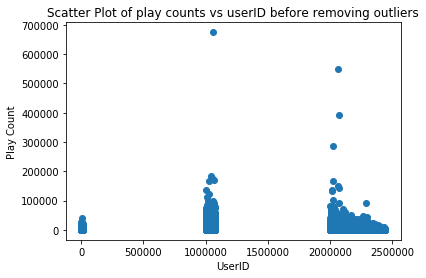

In [190]:
plt.scatter([w[0] for w in user_pc_sum],[w[1] for w in user_pc_sum])
plt.title("Scatter Plot of play counts vs userID before removing outliers")
plt.xlabel('UserID')
plt.ylabel('Play Count')
plt.show()

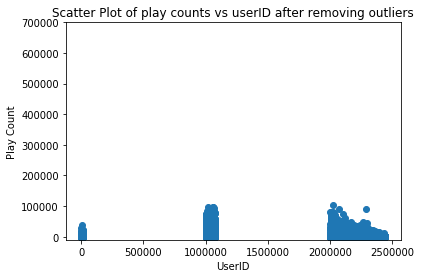

In [191]:
plt.scatter([w[0] for w in user_pc_filtered],[w[1] for w in user_pc_filtered])
plt.title("Scatter Plot of play counts vs userID after removing outliers")
plt.xlabel('UserID')
plt.ylabel('Play Count')
plt.ylim(-10000,700000)
plt.show()

<div class="alert alert-warning">From the graphs, it seems that a big part of the outliers have been removed.<br><br>Let's get the user IDs of the unwanted users and store them in a list so to remove them from our data.</div>

In [57]:
bad_userID=[w[0] for w in user_pc_sum if w[1]>threshold] #all users above threshold

In [58]:
bad_userID

[1059637,
 2064012,
 2069337,
 2023977,
 1046559,
 1052461,
 1070932,
 1031009,
 2020513,
 2062243,
 2069889,
 1001440,
 2014936,
 2017397,
 1024631,
 1007308]

<div class="alert alert-warning">Let's look a bit more into the names of the artists. </div>

In [135]:
#1) left outer join of artistDF and artistAliasDF
#2) selecting only the needed columns and collecting

artistAliasDF3=artistAliasDF.join(artistDF,artistAliasDF.standardID==artistDF.artistID,'left_outer')\
                            .select('standardID','name').collect() 




In [136]:
artistAliasDF3=set(artistAliasDF3) # in order to remove any duplicates

In [141]:
list(artistAliasDF3)[:50] #change to list in order to index

[Row(standardID=2065951, name='Re:Ignition'),
 Row(standardID=1009346, name='King Biscuit Time'),
 Row(standardID=1025011, name='David Crosby'),
 Row(standardID=1026740, name='T-Spoon'),
 Row(standardID=1260286, name='F4T4L_3RR0R'),
 Row(standardID=5943, name='Antipop Consortium'),
 Row(standardID=1000254, name='VAST'),
 Row(standardID=1002512, name='Jim Reeves'),
 Row(standardID=1072747, name='John Hudak'),
 Row(standardID=1021541, name='Enthroned'),
 Row(standardID=5668, name='Monster Magnet'),
 Row(standardID=1045717, name='Fingathing'),
 Row(standardID=6752161, name='Micah P. Hinson'),
 Row(standardID=1002623, name='Haddaway'),
 Row(standardID=1003557, name='Paul Simon'),
 Row(standardID=1088116, name='Irena Santor'),
 Row(standardID=1272832, name='The Impossible Shapes'),
 Row(standardID=1130149, name='Benny Goodman Quartet'),
 Row(standardID=1237851, name='The Lyndsay Diaries'),
 Row(standardID=1141313, name='Johnny'),
 Row(standardID=9951313, name='Big Punisher vs. Mark Morrison

In [144]:
artistDF[artistDF.name=="36481?"].show()

+--------+------+
|artistID|  name|
+--------+------+
| 1301969|36481?|
+--------+------+



In [146]:
newUserArtistDF[newUserArtistDF.artistID==1199629].show()#user is in this DataFrame

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1001587| 1199629|        3|
|1002155| 1199629|       25|
|1005369| 1199629|        1|
|1005369| 1199629|       64|
|1009806| 1199629|       15|
|1009806| 1199629|        5|
|1023934| 1199629|        3|
|1026947| 1199629|       30|
|1026947| 1199629|        4|
|1030777| 1199629|       12|
|1037175| 1199629|       40|
|1037175| 1199629|        3|
|1040487| 1199629|        3|
|1045220| 1199629|       13|
|1051505| 1199629|        7|
|1051505| 1199629|        1|
|1052163| 1199629|        4|
|1054663| 1199629|        2|
|1057289| 1199629|        1|
|1059242| 1199629|        4|
+-------+--------+---------+
only showing top 20 rows



In [147]:
get_artist_name(1199629)#name of user

'Small Brown Bike and The Casket Lottery'

In [148]:
newUserArtistDF[newUserArtistDF.artistID==1234885].show()#user is in this DataFrame

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000206| 1234885|        1|
|1000308| 1234885|        1|
|1000446| 1234885|        3|
|1000499| 1234885|        2|
|1000758| 1234885|        3|
|1001398| 1234885|       25|
|1001562| 1234885|       48|
|1001587| 1234885|       17|
|1001808| 1234885|        2|
|1002062| 1234885|        1|
|1002155| 1234885|        3|
|1002276| 1234885|       10|
|1002624| 1234885|        1|
|1003225| 1234885|       17|
|1003604| 1234885|        2|
|1005365| 1234885|        1|
|1005369| 1234885|       56|
|1005369| 1234885|      278|
|1006054| 1234885|        1|
|1006306| 1234885|        1|
+-------+--------+---------+
only showing top 20 rows



In [149]:
get_artist_name(1234885)#name of this user

'The Casket Lottery'

<div class="alert alert-warning">With all the cleaning that we done, we still have some problems. If we skim through the above names, we can see some strange things. We have an artist whose name is <b>36481?</b>. One at first thought might consider this as unclean data, however the artist <a href="https://www.last.fm/music/36481%3F">exits</a>.<br><br> Another thing is that we still have an artist ID that maps to two or more artist names eventhough some of these artists might have a unique artistID. For example, the artist <b>The Casket Lottery</b> with ID <b>1234885</b> occurs one time, however, if we look at the artist whose ID is <b>1199629</b>, we find that the artist is <b>Small Brown Bike and The Casket Lottery</b>. We see here that we missed some play counts of the artist <b>The Casket Lottery</b>.<br><br> In addition,our <b>newUserArtistDF</b> containts the artistID <b>6918062</b>  which corresponds to the artists <b>Dr.Dre, Eminem, Nate Dogg, Snoop Dogg, Xzibit</b>.<br><br> This might pose a big problem if a certain artist has many collaborations with other artists and in this case, his play count may vary a little.<br><br>
Also, we can observe an artist who has a name <b>The Lion King</b>. Instead of using the name of the artist who sung the movie's soundtrack, the movie name is inserted instead. A possible reason for that is that the movie name is much more famous than the artist herself (Carmen Twillie)who sung the song. Putting her name wouldn't bring more play counts than if the movie name was put.
</div>

<div class="alert alert-warning">Moreover, we have artists with weird names. Some have very weird characters. There is one written in hexadecimal format by mistake.</div>

In [197]:
artistDF[locate("\\x", artistDF.name) > 0].show(20,truncate=False)


+--------+----------------+
|artistID|name            |
+--------+----------------+
|10418113|\x{9921}\x{821E}|
+--------+----------------+



In [198]:
newUserArtistDF[newUserArtistDF.artistID==10418113].show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|2030966|10418113|        1|
+-------+--------+---------+



<div class="alert alert-warning">We must accept the fact the no dataset can be cleaned 100%. We will remove the outliers and remove the bad artists. But for the artists with weird names, is it worth going through the entire dataset to correct them? The artists with the weird characters only form a small portion and will not affect the play count of the single artists. So, we will leave them and will remove the outliers and the bad artists.</div>

In [79]:
for w in bad_userID:
    newUserArtistDF=newUserArtistDF[newUserArtistDF.userID!=w]

In [80]:
for w in bad_artistID:
    newUserArtistDF=newUserArtistDF.filter(newUserArtistDF.artistID!=w)

In [86]:
newUserArtistDF = newUserArtistDF.cache()

<div class="alert alert-danger"><b>End of Experiment</b></div>

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [87]:

uniqueArtists = newUserArtistDF.select("artistID").distinct().count()

print("Total n. of artists: ", uniqueArtists)


Total n. of artists:  1566330


In [ ]:
# Before Cleaning the data 
#Total n. of artists:  1568126


In [90]:

uniqueUsers = newUserArtistDF.select("userID").distinct().count()

print("Total n. of users: ", uniqueUsers)


Total n. of users:  148064


In [ ]:
#Before Cleaning the data
#Total n. of users:  148111

<div class="alert alert-warning">The numbers have decreased a lot after cleaning the data.</div>

<div class="alert alert-danger"> <b>Experiment</b> <br>
I want to see how sparse is the utility matrix.</div>

In [88]:
number_rows= newUserArtistDF.count()
print("Total number of defined items in the utility matrix: ",number_rows)


Total number of defined items in the utility matrix:  24232569


In [91]:
number_elements=uniqueUsers*uniqueArtists
print("Total number of items (defined and undefined) in the utility matrix: ",number_elements)

Total number of items (defined and undefined) in the utility matrix:  231917085120


In [92]:
#number_elements - number_rows give us the number of undefined elements in the matrix, that is, values we want to predict
#sparsity percentage is the percentage of the number of undefined elements to the total number of elements
sparsity_prcnt=(number_elements-number_rows)/number_elements*100
print("Sparsity % of the utility matrix: ",sparsity_prcnt)

Sparsity % of the utility matrix:  99.98955119283796


<div class="alert alert-danger"> <b>End of Experiment</b> </div>

<div class="alert alert-warning">Let's visualize some artists along with their play counts.</div>

In [93]:
#this function draws for a given userID a scatter plot for the artists vs play counts
def graph_user(userID):
    df=newUserArtistDF[newUserArtistDF.userID==userID].toPandas()
    pc_01=df[df['playCount'].values==1]['playCount'].count()#this variables stores the number of play counts which are equal to 1 for the given userID
    pc_tot=df['playCount'].sum()#this variables stores the total number of play counts for the given userID
    print("For the user with ID:",userID,", we have",pc_01,"play counts out of",pc_tot,"which are equal to 1.")
    plt.figure(figsize=(35, 10))
    sc=plt.scatter(x=list(range(df['artistID'].count())), y=df['playCount'].values, c=df['playCount'].values, cmap='viridis')
    plt.colorbar(sc)
    plt.show()

    
    
    



For the user with ID: 2286103 , we have 95 play counts out of 3496 which are equal to 1.


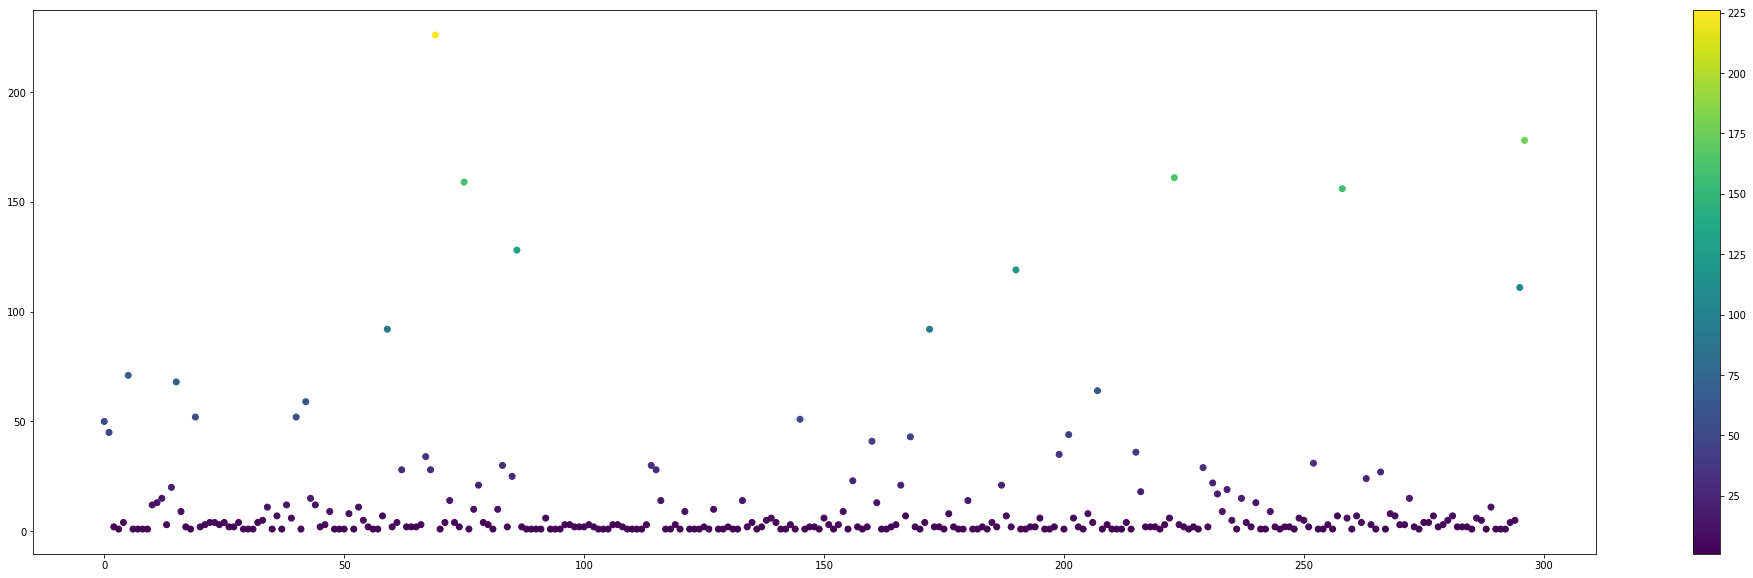

In [94]:
graph_user(2286103)

For the user with ID: 1000002 , we have 313 play counts out of 11357 which are equal to 1.


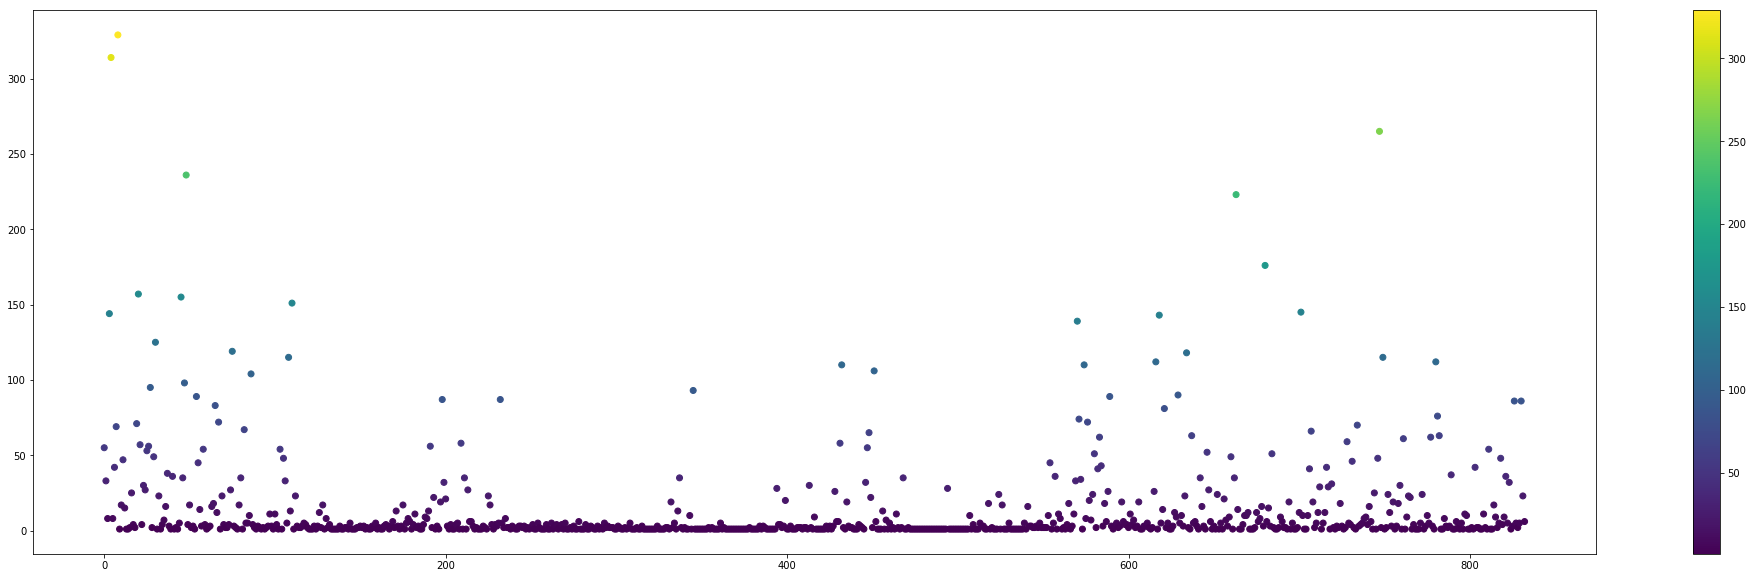

In [95]:
graph_user(1000002)

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

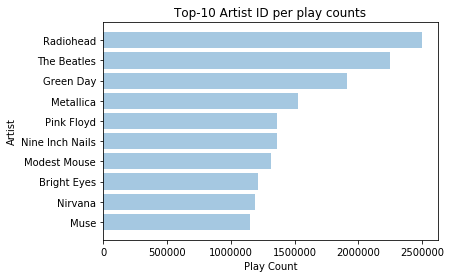

In [32]:
# calculate top-10 artists in term of play counts
top10ArtistsPC = newUserArtistDF.groupBy("artistID").sum("playCount").orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
top10ArtistsPC_names=[get_artist_name(int(w)) for w in pdf[0][::-1].values]
plt.yticks(y_pos, top10ArtistsPC_names)
#plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()


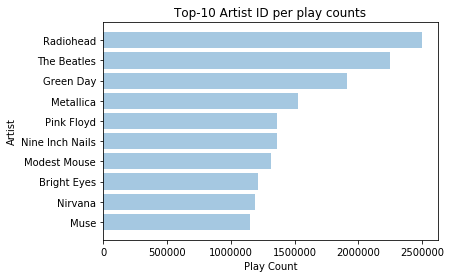

In [214]:
##BEFORE CLEANING
# calculate top-10 artists in term of play counts
top10ArtistsPC = newUserArtistDF.groupBy("artistID").sum("playCount").orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
top10ArtistsPC_names=[get_artist_name(int(w)) for w in pdf[0][::-1].values]
plt.yticks(y_pos, top10ArtistsPC_names)
#plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()


<div class="alert alert-warning">We see here the top 10 artists per play counts. The result looks fine since all bands are well known. However,we don't take into account the time of each band. We have some bands that have been formed a long time ago, such as <b>Pink Floyd</b> which was formed in <b>1965</b> and was <a href="https://en.wikipedia.org/wiki/Pink_Floyd">active</a> until <b>2014</b>. We also have bands such as <b>Bright Eyes</b> which was formed in <b>1995</b> and stopped its <a href="https://en.wikipedia.org/wiki/Bright_Eyes_(band">activity</a> in <b>2011</b>. <br><br>The result doesn't vary a lot before and after cleaning the data.</div>

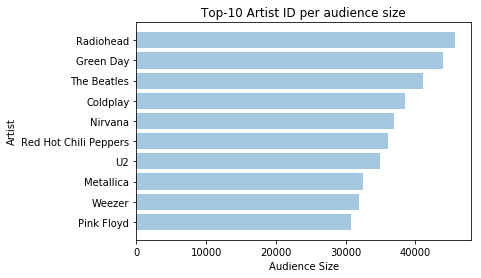

In [220]:
# calculate top-10 artists in term of audience size
top10ArtistsPC = newUserArtistDF.groupBy("artistID").count().orderBy('count', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
top10ArtistsPC_names=[get_artist_name(int(w)) for w in pdf[0][::-1].values]
plt.yticks(y_pos, top10ArtistsPC_names)
#plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Audience Size')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size')
plt.show()

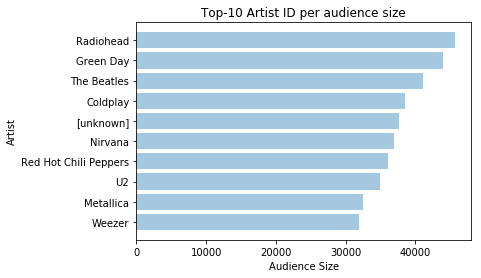

In [103]:
##BEFORE CLEANING
# calculate top-10 artists in term of audience size
top10ArtistsPC = newUserArtistDF.groupBy("artistID").count().orderBy('count', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
top10ArtistsPC_names=[get_artist_name(int(w)) for w in pdf[0][::-1].values]
plt.yticks(y_pos, top10ArtistsPC_names)
#plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Audience Size')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size')
plt.show()

<div class="alert alert-warning">We see here that if we didn't clean the data, the artists <b>[unknown]</b> appears.</div>

<div class="alert alert-warning">Let's update our <b>graph_artists</b> function.</div>

In [239]:
def graph_artist(artistID):
    df=newUserArtistDF[newUserArtistDF.artistID==artistID].toPandas()
    plt.figure(figsize=(20, 10))
    print("This artist has been listened by",df['artistID'].count(),"users with a total play count of",df['playCount'].sum(),".")
    sc=plt.scatter(x=list(range(df['artistID'].count())), y=df['playCount'].values, c=df['playCount'].values, cmap='viridis')
    plt.colorbar(sc)
    plt.show()
    
    

This artist has been listened by 26690 users with a total play count of 1027631 .


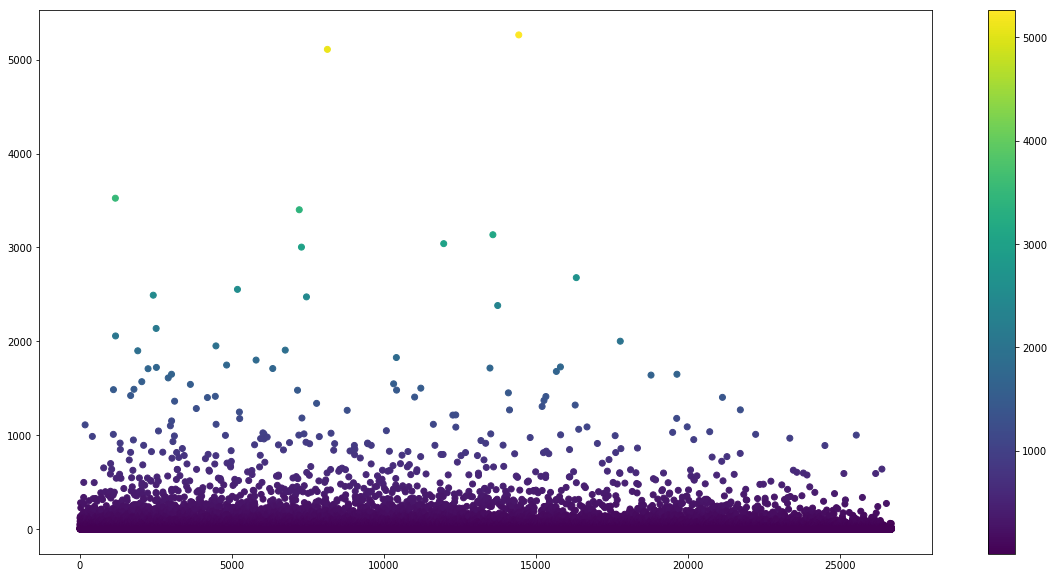

In [240]:
graph_artist(1854)

This artist has been listened by 17984 users with a total play count of 267074 .


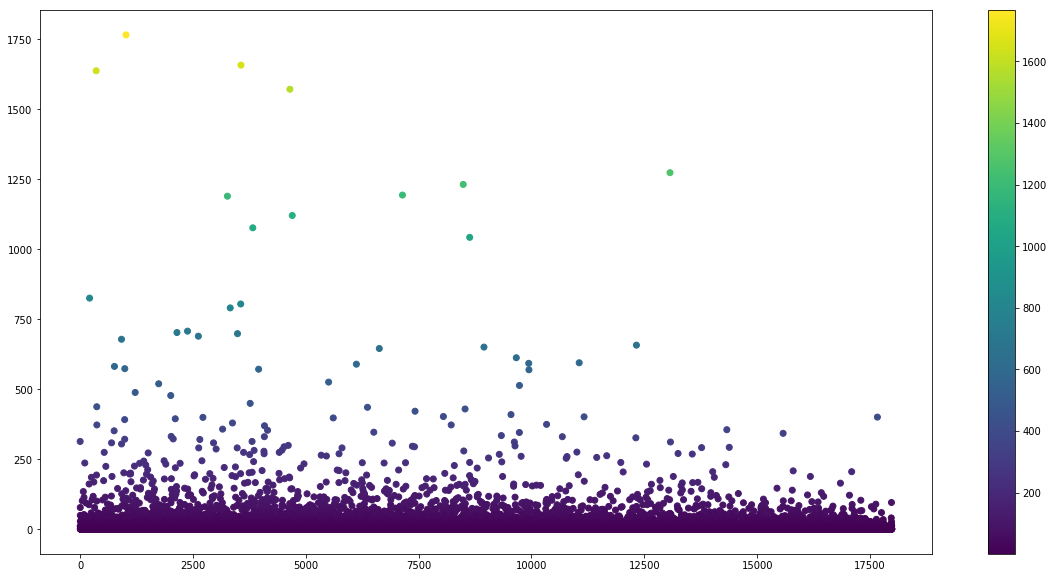

In [241]:
graph_artist(1000010)

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

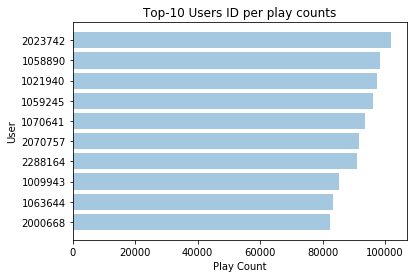

In [242]:

# calculate top 10 users interm of play counts
top10UsersByPlayCount = newUserArtistDF.groupBy("UserID").sum("playCount").orderBy('sum(playCount)',ascending=0).take(10)

y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()


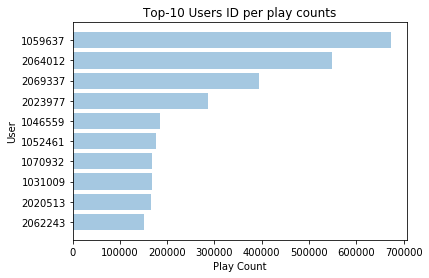

In [243]:
#BEFORE CLEANING
# calculate top 10 users interm of play counts
top10UsersByPlayCount = userArtistDF.groupBy("UserID").sum("playCount").orderBy('sum(playCount)',ascending=0).take(10)

y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()


<div class="alert alert-warning">There is a users who has a play count of <b>674412</b>. If we consider the average song to be of 4 minutes, then:</div>

In [140]:
pdf[1][0]*4 #max play count value * 4 mins/play count

2697648

In [144]:
pdf[1][0]*4/60/24/365#max play count value * 4 mins/play count /(60mins/hr)/(24 hr/day)/(365 days/year)

5.132511415525115

<div class="alert alert-warning">The total time played by the user is approximately <b>5 years</b>. We can see that we removed this outlier and the results after cleaning the data seem reasonable.</div>

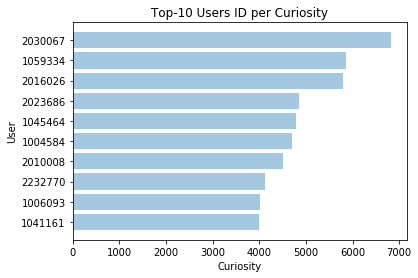

In [244]:

# calculate top 10 users interm of curiosity
top10UsersByCuriosity = (
                            newUserArtistDF.groupBy('userID') \
                            .count()
                            .orderBy('count', ascending=0).take(10)
                         )

y_pos = range( len(top10UsersByCuriosity) )
pdf = pd.DataFrame(data=top10UsersByCuriosity)

plt.barh( y_pos, pdf[1][::-1], align='center', alpha=0.4 )
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Curiosity')
plt.ylabel('User')
plt.title('Top-10 Users ID per Curiosity')
plt.show()



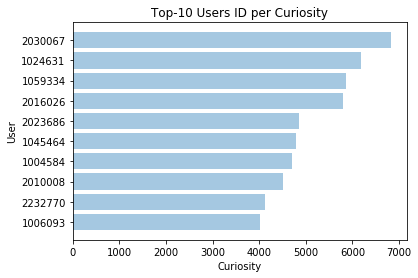

In [145]:
#Before Cleaning
# calculate top 10 users interm of curiosity
top10UsersByCuriosity = (
                            newUserArtistDF.groupBy('userID') \
                            .count()
                            .orderBy('count', ascending=0).take(10)
                         )

y_pos = range( len(top10UsersByCuriosity) )
pdf = pd.DataFrame(data=top10UsersByCuriosity)

plt.barh( y_pos, pdf[1][::-1], align='center', alpha=0.4 )
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Curiosity')
plt.ylabel('User')
plt.title('Top-10 Users ID per Curiosity')
plt.show()



<div class="alert alert-warning">We can see that the results for <b>Curiosity</b> are reasonable and didn't vary a lot before and after cleaning the data.</div>

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [96]:

rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( lambda row: xtractFields(row) ) 
    
                    # fileter out the special tuples
                    .filter( lambda row: row!=(-1,-1))
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
              )


#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast varible can help us increase the effiency.

In [97]:

bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(artistID,artistID)
    return (userID, finalArtistID, count)

userArtistDataRDD = rawUserArtistData.map(lambda x: disambiguate(x))
userArtistDataRDD.take(5)


[('1000002', '1', '55'),
 ('1000002', '1000006', '33'),
 ('1000002', '1000007', '8'),
 ('1000002', '1000009', '144'),
 ('1000002', '1000010', '314')]

In [98]:
userArtistDataRDD=userArtistDataRDD.filter(lambda x: int(x[0]) not in bad_userID) #removing bad user ids, x[0]=userID

In [99]:
userArtistDataRDD=userArtistDataRDD.filter(lambda x: int(x[1]) not in bad_artistID) #removing bad artist ids, x[1]=artistID

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [100]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [101]:

# after replacing mispelled artist ids, the data contains some play count duplications of a user with the same artist
# remember to aggregate these records

#   x[0]=userID x[1]=artistID x[2]=playCount

#1) map to (k,v) where k=(userID,artistID),v=playCount
#2) group by key and sum all values
#3) cast to string
#4) change values to Rating object,partition data into 4 partitions since we have 4 workers,cache
allData = userArtistDataRDD.map(lambda x: ((int(x[0]),int(x[1])),int(x[2])))\
                           .groupByKey().map(lambda x: (x[0],np.sum(list(x[1])))) \
                           .map(lambda x:(str(x[0][0]),str(x[0][1]),str(x[1]))) \
                           .map(lambda r: Rating(r[0], r[1], r[2])).repartition(4).cache()


In [102]:
allData.take(5)

[Rating(user=1001190, product=1268164, rating=1.0),
 Rating(user=1001220, product=630, rating=2.0),
 Rating(user=1001233, product=1001365, rating=18.0),
 Rating(user=1001250, product=352, rating=35.0),
 Rating(user=1001301, product=1131669, rating=3.0)]

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [103]:

t0 = time()
model = ALS.trainImplicit( allData,rank=10, iterations=5, lambda_=0.01, alpha=1.0 )
t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 62.342495 secs


#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [104]:

! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
t0=time()
model.save( sc , "lastfm_model.spark")
t1=time()
print("saving model took %f secs" %(t1-t0))

Deleted lastfm_model.spark
saving model took 6.213742 secs


#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [105]:

t0 = time()
model = MatrixFactorizationModel.load(sc, "lastfm_model.spark")
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))


finish loading model in 2.180217 secs


#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [106]:

model.userFeatures().take(1)


[(116,
  array('d', [-0.03254683315753937, -0.03357991948723793, 0.0538683757185936, -0.05255869776010513, 0.01639435812830925, 0.03259437531232834, 0.013649499975144863, 0.02228485234081745, 0.01857861317694187, 0.036415114998817444]))]


<div class="alert alert-warning">
The output of the function <b>userFeatures()</b> is an RDD where the first element is the <b>userID</b> and the second element is an array of features of length 10 corresponding to that user.</div>


### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [107]:

# Make five reccommendations to user 2093760
recommendations = (model.recommendProducts(2093760,5))

# construct set of recommendated artists
recArtist = set( recommendations )


In [108]:
recArtist

{Rating(user=2093760, product=2814, rating=0.030328749651526425),
 Rating(user=2093760, product=4605, rating=0.029594040592966803),
 Rating(user=2093760, product=1007614, rating=0.029696181143374252),
 Rating(user=2093760, product=1037970, rating=0.029939635902438956),
 Rating(user=2093760, product=1300642, rating=0.030099678603895792)}

In [109]:

# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)


In [110]:
recArtist_list=[w[1] for w in recArtist]
recArtist_list

[1037970, 1007614, 2814, 4605, 1300642]

In [111]:

# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist_list): #w[1] for w in recArtist in for loop was not working
        return True
    else:
        return False

recList = artistByID.filter(artistNames).values().collect()

print(recList)


['50 Cent', 'Snoop Dogg', 'Jay-Z', 'Kanye West', 'The Game']


In [ ]:
#BEFORE CLEANING
#['50 Cent', 'Snoop Dogg', 'Ludacris', '2Pac', 'The Game']


<div class="alert alert-warning">Let's try with 2 different users that have the IDs <b>1001190</b> and <b>1001301</b>.</div>

In [112]:

# Make five reccommendations to user 1001190
recommendations = (model.recommendProducts(1001190,5))

# construct set of recommendated artists
recArtist = set( recommendations )


In [113]:
recArtist_list=[w[1] for w in recArtist]
recArtist_list

[5811, 251, 1014531, 1501, 4377]

In [114]:



recList = artistByID.filter(artistNames).values().collect()

print(recList)


['Billy Idol', 'Ludwig van Beethoven', 'The Pogues', 'Wolfgang Amadeus Mozart', 'Blue Öyster Cult']


In [115]:

# Make five reccommendations to user 1001301
recommendations = (model.recommendProducts(1001301,5))

# construct set of recommendated artists
recArtist = set( recommendations )


In [116]:
recArtist_list=[w[1] for w in recArtist]
recArtist_list

[1428, 1000113, 1205, 1270, 1000010]

In [117]:


recList = artistByID.filter(artistNames).values().collect()

print(recList)


['Eric Clapton', 'Queen', 'The Beatles', 'Aerosmith', 'U2']


<div class="alert alert-danger">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [118]:

def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [119]:

trainData, cvData = allData.randomSplit([0.9,0.1])
trainData.cache()
cvData.cache()


PythonRDD[431] at RDD at PythonRDD.scala:48

In [120]:

t0 = time()
model = ALS.trainImplicit( trainData,rank=10,iterations=5,lambda_=0.01,alpha=0.1 )
t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 71.466020 secs


#### Area under the ROC curve: a function to compute it

In [121]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [122]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [128]:

t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))


auc= 0.9788268278230671
finish in 34.390719 seconds


In [ ]:
#Before CLEANING
#auc= 0.9643564923181464
#finish in 49.549807 seconds


<div class="alert alert-warning">
The <b>AUC</b> enhanced a bit after cleaning the data.
</div>

In [129]:
allData.take(2)

[Rating(user=1001190, product=1268164, rating=1.0),
 Rating(user=1001220, product=630, rating=2.0)]

#### Question 9.3
<div class="alert alert-info">
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [130]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda x,y: x+y).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( r[1] , 0.0)))


In [131]:

auc = calculateAUC(allData, bListenCount, predictMostListened)
print(auc)


0.9527114396727269


In [ ]:
#BEFORE CLEANING
#0.9526575226200217



<div class="alert alert-warning">
We see that before cleaning the data,the model using ALS produced higher accuracy. Although the difference might be small,but companies such as Netflix are willing to pay a lot for this small increase.<br><br>After cleaning the data, the ALS model produced again a better result. 
</div>

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

In [59]:

evaluations = []

for rank in [10,30, 50,100]:
    for lambda_ in [1.0,0.5,0.0001]:
        for alpha in [1.0,10.0,40.0,75.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit( trainData,rank, 5,lambda_, alpha=alpha)
            
            auc = calculateAUC(cvData , bAllItemIDs, model.predictAll)
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

evaluations.sort( key=lambda x: -x[1] )
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()


Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=10.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=1.000000 alpha=75.000000
Train model with rank=10 lambda_=0.500000 alpha=1.000000
Train model with rank=10 lambda_=0.500000 alpha=10.000000
Train model with rank=10 lambda_=0.500000 alpha=40.000000
Train model with rank=10 lambda_=0.500000 alpha=75.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=10.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=75.000000
Train model with rank=30 lambda_=1.000000 alpha=1.000000
Train model with rank=30 lambda_=1.000000 alpha=10.000000
Train model with rank=30 lambda_=1.000000 alpha=40.000000
Train model with rank=30 lambda_=1.000000 alpha=75.000000
Train model with rank=30 lambda_=0.500000 alpha=1.000000
Train model with ra

PythonRDD[248] at RDD at PythonRDD.scala:48


<div class="alert alert-warning">
The <b>alpha</b> parameter seems better at high values. This means that the model is better off focusing on what the user did listen to than what he or she did not listen to.<br> A high <b>lambda</b> is better. This means that our model is vulnerable to overfitting and we need a higher <b>lambda</b> to resist overfitting.<br>The number of <b>features</b> doesn't seem to affect a lot our accuracy. This might mean that may be the model is better at values higher than the ones stated above.<br>The values stated here don't mean they are the best. We might find values wich are better. It is a matter of bruteforce.
</div>

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

In [132]:

model = ALS.trainImplicit(trainData, rank=30, iterations=5, lambda_=1.0, alpha=75.0)
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(2093760,5)

recommendedProductIDs = set( recommendations )
recArtist_list=[w[1] for w in recommendedProductIDs]

recList = artistByID.filter(artistNames).values().collect()
print(recList)

unpersist(model)


['Jack Johnson', 'Eminem', 'Jimmy Eat World', 'Green Day', 'blink-182']


In [ ]:
#Several Results Before Cleaning data
#['Various Artists', 'U2', 'Linkin Park', 'Green Day', 'blink-182']
#['[unknown]', 'U2', 'Linkin Park', 'Green Day', 'blink-182']
#['Eminem', 'The Killers', 'U2', 'Green Day', 'blink-182']




<div class="alert alert-warning">
We can see here to clean data,we redid the notebook a couple of times. Data science is an iterative process!<br>
However,we still have some unclean data.
</div>


<div class="alert alert-danger">
<b>Experiment</b>: Apriori Learning</div>

Apriori Learning is a kind of Associate Learning,i.e., it associates two items together. For example, in a grocery store it seems logical to put __formage blanc__ and __honey__ under the same shelf,as they are often bought together. We do this by observing how many times people have bought both items together.<br><br>
There are __three__ common ways to measure association:
- __Support__: This expresses how much an item is popular. For example,in a grocery store, the __Support__ of buying an apple is the number of times and apple has been bought divided by the total number of transactions.
- __Confidence__: This measures how likely an item Y is to be bought with an item X. It is defined as __Support(X,Y)/Support(X)__ where __Support(X,Y)__ is the number of times the items X&Y are bought together divided by the total number of transactions.
- __Lift__:One drawback of the __Confidence__ measure is that it accounts for how an item X is popoular and doesn't take into account the popularity of item Y.The __Lift__ measure solves this problem by incorporating the popularity of Y.<br> __Confidence =Support(X,Y)/Support(Y)__<br> In this measure, if both X and Y are popular and occur frequently,then there is a high chance that they can be associated together.


<div class="alert alert-danger">
<b>Code</b></div>

In [112]:
total_pc=newUserArtistDF[['playCount']].groupBy().sum('playCount').collect()[0][0] #total number of play counts

def support_artist(artistID):
    artist_pc=newUserArtistDF[newUserArtistDF.artistID==artistID].groupBy().sum('playCount').collect()[0][0]
    return artist_pc/total_pc

def support_user(userID):
    user_pc=newUserArtistDF[newUserArtistDF.userID==userID].groupBy().sum('playCount').collect()[0][0]
    return user_pc/total_pc

#please read the below cell

'''def confidence(userID,artistID):
    user_artist_pc=newUserArtistDF[newUserArtistDF.artistID==artistID][newUserArtistDF.userID==userID]\
                   .groupBy().sum('playCount').collect()[0][0]
    print(type(user_artist_pc),user_artist_pc,type(total_pc),total_pc)
    return ((user_artist_pc/total_pc)/support_artist(artistID))

def lift (userID,artistID):
    #return confidence(userID,artistID)/support_user(userID)
    return support_user(userID)*support_artist(artistID)*10**10''''''
    


    
    


<div class="alert alert-warning">
What we learned here is that ,in a recommender system, associate learning doesn't apply as we can't associate a user to an artist, because we need to recommend to the user an artist that he has never listened to before and we can't compute the number of items that this user has listened to this specific artist.<br>
</div>


<div class="alert alert-danger">
<b>End of Experiment</b></div>

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

#  Acknowledgements and References

- This notebook wouldn't be completed without the help of Prof. Pietro Michiardi and the teaching assistants.
- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)
- [This](https://www.kdnuggets.com/2016/04/association-rules-apriori-algorithm-tutorial.html) webpage. 
- [This](https://perso.telecom-paristech.fr/qleroy/aml/lab2.html) notebook.
- [This](https://datascience.ibm.com/exchange/public/entry/view/99b857815e69353c04d95daefb3b91fa) notebook.

